# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [42]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import tools_condition, ToolNode
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from IPython.display import display, Markdown, Image
from langchain.tools import tool
from typing_extensions import TypedDict, Literal
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt

load_dotenv()

True

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [3]:
model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
model.invoke("hello").content

'Hello! How can I assist you today?'

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [4]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [5]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [6]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [7]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

In [8]:
# Connect tools to a chat model
model_with_tools = model.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [9]:
type(output)

langchain_core.messages.ai.AIMessage

In [10]:
output

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 67, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-CvoooQt7WtPqxTyvqRvZkt4dkgScW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b9ed1-5170-7e82-915a-c759b3a1a862-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'boss@company.ai', 'subject': "Re: Tomorrow's Meeting", 'content': "Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. \n\nPlease let me know if ther

In [11]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. \n\nPlease let me know if there are any specific topics you would like me to focus on or if there are any changes to the agenda.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]"}

In [17]:
args['to']

'boss@company.ai'

In [15]:
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Subject: Re: Tomorrow's Meeting

Dear [Boss's Name],

Thank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. 

Please let me know if there are any specific topics you would like me to focus on or if there are any changes to the agenda.

Looking forward to our discussion.

Best regards,

[Your Name]

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

In [16]:
class StateSchema(TypedDict):
    request: str
    email: str

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [22]:
def chatNode(state: StateSchema) -> StateSchema:
    
    request = state["request"]
    model_with_tools = model.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)
    response = model_with_tools.invoke(request)
    args = response.tool_calls[0]['args']

    email = write_email.invoke(args)
    return {"request": request, "email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [24]:
builder = StateGraph(StateSchema)

builder.add_node("chat", chatNode)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

graph = builder.compile()

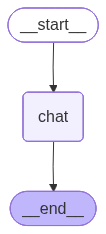

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
response = graph.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

In [29]:
Markdown(response['email'])

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Subject: Re: Tomorrow's Meeting

Dear [Boss's Name],

Thank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. 

Please let me know if there are any specific topics you would like me to focus on or if there are any changes to the agenda.

Looking forward to our discussion.

Best regards,

[Your Name]

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [49]:
def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    sys_msg = SystemMessage(content="You are a helpful assistant tasked with writing emails.")
    model_with_tools = model.bind_tools([write_email])
    output = model_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [output]}

In [50]:
# Create state graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("call_llm", call_llm)
workflow.add_node("tools", ToolNode([write_email]))

# Add edges
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", tools_condition)
workflow.add_edge("tools", END)

# Compile graph
graph = workflow.compile()

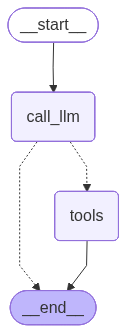

In [51]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
result = graph.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_Nveee7nABqWUuRmU77MuQAXh)
 Call ID: call_Nveee7nABqWUuRmU77MuQAXh
  Args:
    to: boss@company.ai
    subject: Confirmation to Attend Interrupt!
    content: Dear [Boss's Name],

I hope this message finds you well. I am writing to confirm my attendance at Interrupt! I am looking forward to the opportunity to participate and gain valuable insights.

Thank you for the opportunity.

Best regards,

[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation to Attend Interrupt!' and content: Dear [Boss's Name],

I hope this message finds you well. I am writing to confirm my attendance at Interrupt! I am

In [53]:
result = graph.invoke({"messages": [{"role": "user", "content": "Hello, how are you?"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


### **Skipped Below**: [Complete Notebook](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/langgraph_101.ipynb)

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```